# Hamiltonian Monte Carlo with CUQIpy-PyTorch

In this exercise, we will use the [CUQIpy-PyTorch](https://github.com/CUQI-DTU/CUQIpy-PyTorch) to extend CUQIpy by adding the ability to use PyTorch as a backend for array operations. PyTorch enables two main things: 1) GPU acceleration and 2) automatic differentiation.

[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) enables computing the gradient of a function with respect to its input variables automatically using repeated application of the chain rule programmatically. This is useful for many machine learning algorithms, but also in the context of Bayesian inference. In particular, it means that we can automatically compute the gradient of a log-posterior, which could be arbitrarily complex! This provides a huge advantage because we can then sample from the posterior distribution using Hamiltonian Monte Carlo (HMC) and other gradient-based methods.

Hamiltonian Monte Carlo and in particular the [No-U-Turn Sampler](https://arxiv.org/abs/1111.4246) (NUTS) variant is a general but still very efficient sampler for sampling high-dimensional distributions. This is useful when it is not possible to exploit the structure of the posterior distribution using e.g. conjugacy relations, linearity of forward models or other tricks, which in large part is what the main CUQIpy package is all about.

In this way, CUQIpy-PyTorch compliments the main CUQIpy package by adding the option for an efficient sampling technique that works for arbitrary posterior distributions.

Make sure you have installed the plugin (link in first paragraph) before starting this exercise.

## Learning objectives of this notebook:
- ...

## Table of contents: 
* [1. Why Hamiltonian Monte Carlo?](#why-hmc?)
* [2. Hamiltonian Monte Carlo in CUQIpy-PyTorch](#hmc-cuqipy-pytorch)
* [3. Bayesian inverse problems with CUQIpy-PyTorch](#bayesian-inverse-problems)

First we import the necessary packages. Notice we use the PyTorch package `torch` (imported as `xp`) instead of NumPy for arrays and import both `cuqi` and `cuqipy_pytorch` from CUQIpy and CUQIpy-PyTorch, respectively. We also import `matplotlib` for plotting.

In [ ]:
import torch as xp
import numpy as np
import cuqi
import cuqipy_pytorch
import matplotlib.pyplot as plt
import time

## 1. Why Hamiltonian Monte Carlo? <a class="anchor" id="why-hmc"></a>

As mentioned in the introduction, Hamiltonian Monte Carlo (HMC) is a general but still very efficient sampler for sampling high-dimensional distributions. It is beyond the scope of this exercise to go into the details of HMC, but we instead give a short example showing how it compares to using the classical Metropolis-Hastings algorithm. For more details in the theory of HMC, we refer to the [original paper](https://arxiv.org/abs/1206.1901) by Neal and the [No-U-Turn Sampler](https://arxiv.org/abs/1111.4246) (NUTS) variant by Hoffman and Gelman.

Suppose we were aiming to sample from 2 dimensional probability density function shaped like a donut. We could also have selected a higher dimensional example making Metropolis-Hastings look even worse, but it makes visualization more difficult.

This example can be loaded from the `DistributionGallery` class in CUQIpy as follows.

In [141]:
donut = cuqi.distribution.DistributionGallery('donut')

For illustration let us plot the pdf and arrows showing the gradient of the pdf at a few points.

(Currently there is no `plot_pdf` method for CUQIpy distributions, so we must write our own plotting code.)

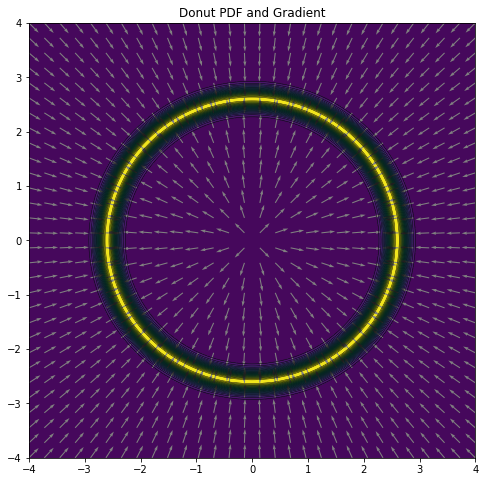

In [142]:
def plot_pdf(dist, plot_grad=False):
    # Ranges for the plot
    m, n, nl, ng = 300, 300, 30, 30
    xmin, xmax, ymin, ymax = -4, 4, -4, 4

    # evaluate PDF
    X, Y = np.meshgrid(np.linspace(xmin, xmax, m), np.linspace(ymin, ymax, n))
    Xf, Yf = X.flatten(), Y.flatten()
    pts = np.vstack([Xf, Yf]).T   # pts is (m*n, d)
    Z = donut.pdf(pts).reshape((m, n))

    if plot_grad:
        # evaluate gradient
        Xg, Yg = np.meshgrid(np.linspace(xmin, xmax, ng), np.linspace(ymin, ymax, ng))
        Xfg, Yfg = Xg.flatten(), Yg.flatten()
        posg = np.vstack([Xfg, Yfg]).T  
        grad = donut.gradient(posg)
        norm = np.linalg.norm(grad, axis=0)
        u, v = grad[0, :]/norm, grad[1, :]/norm

    # plot PDF and gradient
    plt.contourf(X, Y, Z, nl)
    plt.contour(X, Y, Z, nl, linewidths=0.5, colors='k') 
    if plot_grad:
        plt.quiver(posg[:, 0], posg[:, 1], u, v, units='xy', scale=4, color='gray')

plt.figure(figsize=(8, 8))
plot_pdf(donut, plot_grad=True)
plt.title('Donut PDF and Gradient');

We can now sample from the distribution using both the Metropolis-Hastings algorithm and HMC (NUTS). We also store the time it takes to sample from the distribution using each method.

In [143]:
# Metropolis-Hastings
t = time.time()
samples_MH = cuqi.sampler.MetropolisHastings(donut).sample_adapt(N=1000, Nb=1000)
t_MH = time.time() - t

# Hamiltonian Monte Carlo (NUTS)
t = time.time()
samples_NUTS = cuqi.sampler.NUTS(donut).sample_adapt(N=1000, Nb=1000)
t_NUTS = time.time() - t

Sample 2000 / 2000

Average acceptance rate: 0.308 MCMC scale: 0.5240301103707885 

Sample 2000 / 2000


We can then compare the samples obtained from the two methods by plotting the samples in a "pair plot" (a scatter plot of each pair of samples).

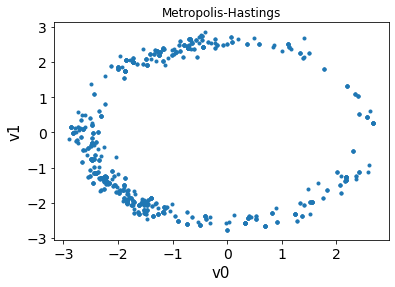

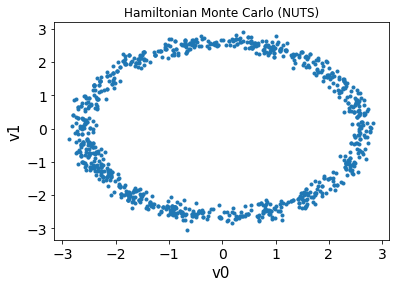

In [144]:
samples_MH.plot_pair()
plt.title('Metropolis-Hastings')
samples_NUTS.plot_pair()
plt.title('Hamiltonian Monte Carlo (NUTS)');

Notice that the samples obtained using HMC are much more evenly distributed than the samples obtained using the Metropolis-Hastings algorithm (which may not even have explored the entire distribution yet).

We can also see that the chains obtained using HMC are much less correlated than the chains obtained using the Metropolis-Hastings algorithm.

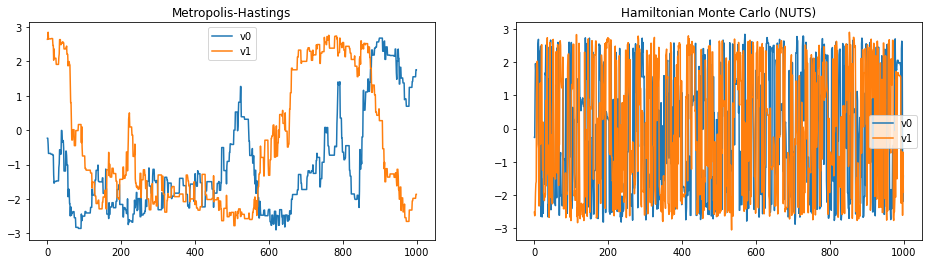

In [145]:
plt.figure(figsize=(16, 4))
plt.subplot(121, title='Metropolis-Hastings')
samples_MH.plot_chain()
plt.subplot(122, title='Hamiltonian Monte Carlo (NUTS)')
samples_NUTS.plot_chain()

Finally, we can compare the effective samples size (ESS) of the two chains. The ESS is a measure of the number of independent samples in a chain. We divide by the total time it took to sample from the distribution to get the effective samples per second (ESS/s). We can see that the ESS/s is much higher for the HMC chain than the Metropolis-Hastings chain.

In [146]:
print(f"MH: Effective samples / second {samples_MH.compute_ess()/t_MH} ")
print(f"NUTS: Effective samples / second {samples_NUTS.compute_ess()/t_NUTS} ")

MH: Effective samples / second [ 6.66874297 13.33469684] 
NUTS: Effective samples / second [48.84545286 39.01742256] 


There is a lot more to say about HMC, but we will leave that for another time. For now, we will move on to using HMC in CUQIpy-PyTorch.

## 2. Hamiltonian Monte Carlo with CUQIpy-PyTorch <a class="anchor" id="hmc-cuqipy-pytorch"></a>

Gradient was implemented manually in example above..

### PyTorch primer

### CUQIpy-PyTorch distributions

Because the `cuqi` distributions are written using NumPy and SciPy, we instead have to use the distributions defined in `cuqi_torch`. These are thin wrappers around PyTorch distributions, but acts as a drop-in replacement for the `cuqi` distributions.

In [131]:
from cuqipy_pytorch.distribution import Gaussian, HalfGaussian, LogGaussian, Uniform, Gamma, StackedJointDistribution

### Sampling from any combination of distributions
We also load the highly optimized NUTS sampler from the `pyro` package, which is conviniently wrapped in the `cuqi_torch` package.

In [132]:
from cuqipy_pytorch.sampler import NUTS

We then define a simple function to sample the posterior given densities and data.

In [133]:
# A convenience function to sample a Bayesian model
def sample(*densities, Ns=500, Nb=500, **data):
    """ Sample given by a list of densities. The observations are given as keyword arguments. """
    P = StackedJointDistribution(*densities)
    return NUTS(P(**data)).sample(Ns, Nb)

### Eight schools model
The eight schools model is a classic example made famous by the Bayesian Data Analysis book by Gelman et. al. 

It is often used to illustrate the notation and code-style of probabilistic programming languages. 

The actual model is explained in the BDA book or in the Edward 1.0 PPL notebook ([link](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb)).

The Bayesian model can be written as

\begin{align*}
    \mu &\sim \mathcal{N}(0, 10^2)\\
    \tau &\sim \log\mathcal{N}(5, 1)\\
    \boldsymbol \theta' &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}_m)\\
    \boldsymbol \theta &= \mu + \tau \boldsymbol \theta'\\
    \mathbf{y} &\sim \mathcal{N}(\boldsymbol \theta, \boldsymbol \sigma^2 \mathbf{I}_m)
\end{align*}

where $\mathbf{y}\in\mathbb{R}^m$ and $\boldsymbol \sigma\in\mathbb{R}^m$ is observed data.

In CUQIpy we can define the model as follows:

In [ ]:
y_obs = xp.tensor([28, 8, -3,  7, -1, 1,  18, 12], dtype=xp.float32)
σ_obs = xp.tensor([15, 10, 16, 11, 9, 11, 10, 18], dtype=xp.float32)

μ     = Gaussian(0, 10**2)
τ     = LogGaussian(5, 1)
θp    = Gaussian(xp.zeros(8), 1)
θ     = lambda μ, τ, θp: μ+τ*θp
y     = Gaussian(θ, cov=σ_obs**2)

samples = sample(μ, τ, θp, y, y=y_obs)

In [ ]:
# Plot posterior samples
samples["θp"].plot_violin(); 
print(samples["μ"].mean()) # Average effect
print(samples["τ"].mean()) # Average variance

In [ ]:
# Plot treatment effect distribution
θs = []
for μs, τs, θps in zip(samples["μ"], samples["τ"], samples["θp"]):
    θs.append(θ(μs, τs, θps))
    
θs = cuqi.samples.Samples(xp.tensor(θs).T)
θs.geometry._name = "θ"
θs.plot_violin();

In [ ]:
import pandas as pd
DATA_URL = "https://raw.githubusercontent.com/fonnesbeck/probabilistic_python/master/data/"
spin_rate_data = pd.read_csv(DATA_URL + "savant_data.csv", parse_dates=["game_date"]).dropna(subset=["spin_rate", "game_date"])

day_ind, date = pd.factorize(spin_rate_data.game_date, sort=True)
spin_rate = spin_rate_data.spin_rate.values
day_ind = xp.tensor(day_ind)

#spin_rate_data.head()
#spin_rate_data.plot.scatter(x="game_date", y="spin_rate", figsize=(14,5), alpha=0.2)

mu = Gaussian(xp.ones(2)*2500, 100)
tau = Uniform(0, 181)
sigma = HalfGaussian(100)
r = lambda tau, mu: xp.where(day_ind < tau, mu[0], mu[1])
sr = LogGaussian(r, lambda sigma: sigma)

samples = sample(mu, tau, sigma, sr, Ns=200, Nb=200, sr=spin_rate)




Main point is that CUQIpy-PyTorch is very flexible and can be used to sample from any combination of distributions.

## 3. Bayesian inverse problems with CUQIpy-PyTorch <a class=" anchor" id="bayesian-inverse-problems"></a>

Still finding its place.. What can it be used for?

Show the Gaussian Deconvolution example.

Show hyper-parameter example (its going to be slow).

Discuss further possibilities.